## Using SOFIE  in Python with Numpy

notebook from tutorial TMVA_SOFIE_Inference.py

In [1]:
import ROOT
import numpy as np

Welcome to JupyROOT 6.29/01


In [2]:
modelFile = "Higgs_trained_model.h5"
if (ROOT.gSystem.AccessPathName(modelFile)) :
    ROOT.Info("TMVA_SOFIE_RDataFrame","You need to run TMVA_Higgs_Classification to generate the Keras trained model")
    exit()

#### 1. Parse the input Keras model into RModel object

In [3]:
model = ROOT.TMVA.Experimental.SOFIE.PyKeras.Parse(modelFile)

Keras Version: 2.9.0
Model has not a defined batch size, assume is 1 - input shape for tensor dense_input : { 1 , 7 }


In [4]:
generatedHeaderFile = modelFile.replace(".h5",".hxx")
print("Generating inference code for the Keras model from ",modelFile,"in the header ", generatedHeaderFile)
#Generating inference code
model.Generate()
model.OutputGenerated(generatedHeaderFile)

Generating inference code for the Keras model from  Higgs_trained_model.h5 in the header  Higgs_trained_model.hxx


In [5]:
model.PrintGenerated()

//Code generated automatically by TMVA for Inference of Model file [Higgs_trained_model.h5] at [Thu Feb  2 20:37:43 2023] 

#ifndef TMVA_SOFIE_HIGGS_TRAINED_MODEL
#define TMVA_SOFIE_HIGGS_TRAINED_MODEL

#include<algorithm>
#include<cmath>
#include<vector>
#include "TMVA/SOFIE_common.hxx"
#include <fstream>

namespace TMVA_SOFIE_Higgs_trained_model{
namespace BLAS{
	extern "C" void sgemv_(const char * trans, const int * m, const int * n, const float * alpha, const float * A,
	                       const int * lda, const float * X, const int * incx, const float * beta, const float * Y, const int * incy);
	extern "C" void sgemm_(const char * transa, const char * transb, const int * m, const int * n, const int * k,
	                       const float * alpha, const float * A, const int * lda, const float * B, const int * ldb,
	                       const float * beta, float * C, const int * ldc);
}//BLAS
struct Session {
std::vector<float> fTensor_dense4bias0 = std::vector<float>(2);
flo

#### 2. Compile the generated model file

In [6]:
modelName = modelFile.replace(".h5","")
print("compiling SOFIE model ", modelName)
ret = ROOT.gInterpreter.Declare('#include "' + generatedHeaderFile + '"')
if not ret:
    print("Error compiling header file ", generatedHeaderFile)
    exit()

compiling SOFIE model  Higgs_trained_model


#### 3. Read input data in Numpy arrays

In [7]:
inputFileName = "Higgs_data.root"
inputFile = "http://root.cern.ch/files/" + inputFileName

Use RDataFrame -> Numpy 

In [8]:
df1 = ROOT.RDataFrame("sig_tree", inputFile)
sigData = df1.AsNumpy(columns=['m_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb'])

In [9]:
print(sigData)

{'m_jj': ndarray([1.35376   , 0.3022199 , 0.90975326, ..., 0.7873357 , 0.9221176 ,
         0.7312851 ], dtype=float32), 'm_jjj': ndarray([0.9795631 , 0.83304816, 1.1083305 , ..., 0.97868377, 1.0380867 ,
         1.0617054 ], dtype=float32), 'm_lv': ndarray([0.97807616, 0.98569965, 0.9856922 , ..., 0.98237854, 0.98750263,
         1.0720345 ], dtype=float32), 'm_jlv': ndarray([0.92000484, 0.9780984 , 0.95133126, ..., 1.1715132 , 0.9512442 ,
         0.78194284], dtype=float32), 'm_bb': ndarray([0.72165745, 0.77973217, 0.8032515 , ..., 0.9685302 , 0.46553683,
         0.87044066], dtype=float32), 'm_wbb': ndarray([0.98875093, 0.99235576, 0.8659244 , ..., 0.9312682 , 0.80048835,
         1.1141888 ], dtype=float32), 'm_wwbb': ndarray([0.87667835, 0.7983426 , 0.7801176 , ..., 0.91213906, 0.80058527,
         0.9691252 ], dtype=float32)}


#### 4. Perform SOFIE inference from numpy arrays

Create SOFIE session class

In [10]:
session = ROOT.TMVA_SOFIE_Higgs_trained_model.Session()

Perform inference on single event (It could be done on a batch of events).

In [11]:
xsig = np.column_stack(list(sigData.values()))
print(xsig.shape)

(10000, 7)


In [12]:
dataset_size = xsig.shape[0]
print("size of data", dataset_size)

size of data 10000


In [13]:
print(xsig[0,:])

[1.35376    0.9795631  0.97807616 0.92000484 0.72165745 0.98875093
 0.87667835]


In [14]:
hs = ROOT.TH1D("hs","Signal result",100,0,1)
for i in range(0,dataset_size):
    result = session.infer(xsig[i,:])
    hs.Fill(result[0])

#### 5. Evaluate model also on background data

In [15]:
# make SOFIE inference on background data
df2 = ROOT.RDataFrame("bkg_tree", inputFile)
bkgData = df2.AsNumpy(columns=['m_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb'])
xbkg = np.column_stack(list(bkgData.values()))


hb = ROOT.TH1D("hb","Background result",100,0,1)
dataset_size = xbkg.shape[0]
for i in range(0,dataset_size):
    result = session.infer(xbkg[i,:])
    hb.Fill(result[0])


#### 6. Plot Results

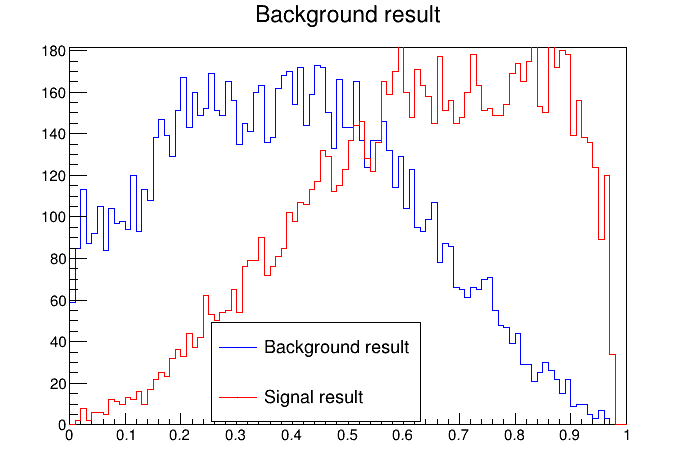

In [16]:
c1 = ROOT.TCanvas()
ROOT.gStyle.SetOptStat(0)
hs.SetLineColor(ROOT.kRed)
hb.SetLineColor(ROOT.kBlue)
hb.Draw()
hs.Draw("SAME")
c1.BuildLegend()
c1.Draw()